In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Customer churn/Train.csv')
test = pd.read_csv('/content/drive/MyDrive/Customer churn/Test.csv')

In [ ]:
print(f"Train Shape : {train.shape}")
print(f"Test Shape : {test.shape}")

Train Shape : (440833, 12)
Test Shape : (64374, 12)


In [ ]:
# Concat Two DataFrames
df = pd.concat([train , test] , axis = 0)
df.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [ ]:
df.shape

(505207, 12)

In [ ]:
print(df.columns)

Index(['CustomerID', 'Age', 'Gender', 'Tenure', 'Usage Frequency',
       'Support Calls', 'Payment Delay', 'Subscription Type',
       'Contract Length', 'Total Spend', 'Last Interaction', 'Churn'],
      dtype='object')


In [ ]:
df.drop('CustomerID' , axis = 1 , inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 505207 entries, 0 to 64373
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Age                505206 non-null  float64
 1   Gender             505206 non-null  object 
 2   Tenure             505206 non-null  float64
 3   Usage Frequency    505206 non-null  float64
 4   Support Calls      505206 non-null  float64
 5   Payment Delay      505206 non-null  float64
 6   Subscription Type  505206 non-null  object 
 7   Contract Length    505206 non-null  object 
 8   Total Spend        505206 non-null  float64
 9   Last Interaction   505206 non-null  float64
 10  Churn              505206 non-null  float64
dtypes: float64(8), object(3)
memory usage: 46.3+ MB


In [ ]:
df.describe()

,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
count,505206.000000,505206.000000,505206.000000,505206.000000,505206.000000,505206.000000,505206.000000,505206.000000
mean,39.704172,31.350435,15.714825,3.833317,13.496843,620.072766,14.610581,0.555203
std,12.670577,17.237482,8.619323,3.133603,8.451187,245.319256,8.608286,0.496944
min,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,29.000000,16.000000,8.000000,1.000000,6.000000,446.000000,7.000000,0.000000
50%,40.000000,32.000000,16.000000,3.000000,13.000000,648.900000,14.000000,1.000000
75%,49.000000,46.000000,23.000000,6.000000,20.000000,824.000000,22.000000,1.000000
max,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


In [ ]:
df.describe(include= 'object')

,Gender,Subscription Type,Contract Length
count,505206,505206,505206
unique,2,3,3
top,Male,Standard,Annual
freq,280273,170630,198608


In [ ]:
for col in df.columns :
    print(col)
    print(df[col].unique())
    print("*******************")

Age
[30. 65. 55. 58. 23. 51. 39. 64. 29. 52. 22. 48. 24. 49. 19. 47. 42. 57.
 27. 59. 21. 60. 35. 18. 56. 20. 63. 25. 28. 32. 38. 37. 31. 53. 41. 33.
 26. 36. 44. 34. 61. 40. 45. 46. 54. 43. 50. 62. nan]
*******************
Gender
['Female' 'Male' nan]
*******************
Tenure
[39. 49. 14. 38. 32. 33. 37. 12.  3. 18. 21. 41. 35.  4. 56. 44. 15. 55.
 43. 52. 26.  2. 29. 59. 40. 51. 53. 24. 30.  6. 28. 17. 60.  7. 34. 10.
  5. 45. 54. 58. 25. 13. 47. 31. 22. 19. 23.  1.  8. 46. 16. 50. 48. 11.
 42. 27.  9. 20. 57. 36. nan]
*******************
Usage Frequency
[14.  1.  4. 21. 20. 25. 12.  8.  5.  9.  6. 17. 23. 13. 16. 27.  2. 28.
 29. 15. 24.  3. 22. 26. 30.  7. 11. 18. 19. 10. nan]
*******************
Support Calls
[ 5. 10.  6.  7.  9.  3.  4.  2.  0.  1.  8. nan]
*******************
Payment Delay
[18.  8.  7. 26. 16. 15.  4. 11. 30. 25. 13. 22.  5. 14.  3. 10. 28.  2.
  6. 27. 12. 29. 17. 24.  9. 23. 21.  1.  0. 20. 19. nan]
*******************
Subscription Type
['Standard' 'Basic' '

In [ ]:
df.isna().sum()

,0
Age,1
Gender,1
Tenure,1
Usage Frequency,1
Support Calls,1
Payment Delay,1
Subscription Type,1
Contract Length,1
Total Spend,1
Last Interaction,1


In [ ]:
df.dropna(inplace = True)

In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
num_col = df.select_dtypes(include='number').columns
cat_col = df.select_dtypes(include='object').columns

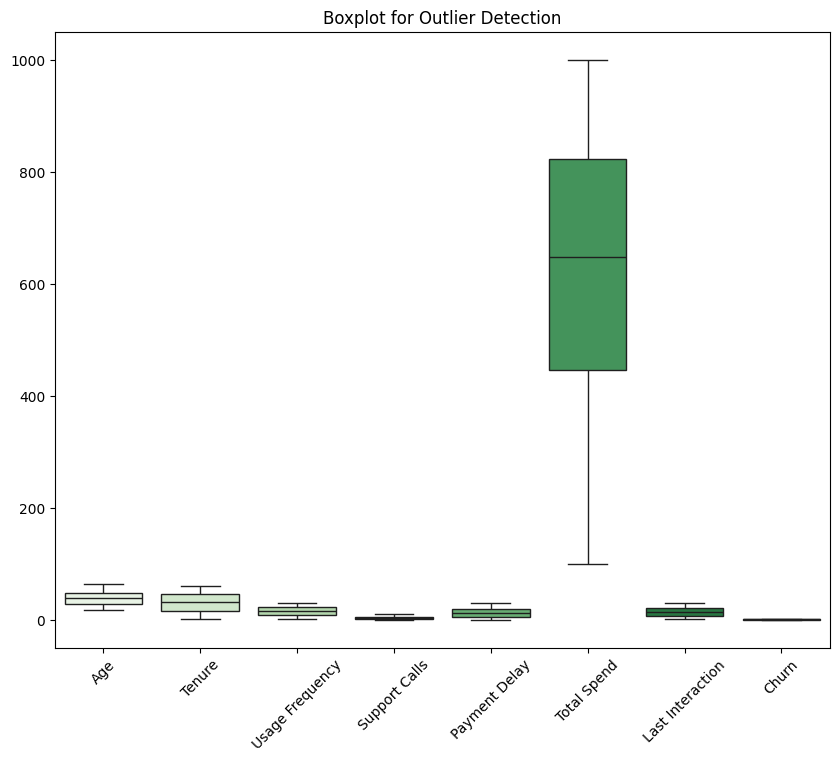

In [ ]:
plt.figure(figsize=(10, 8))
sns.boxplot(data=df[num_col] , palette='Greens')

plt.title('Boxplot for Outlier Detection')
plt.xticks(rotation = 45)
plt.show()

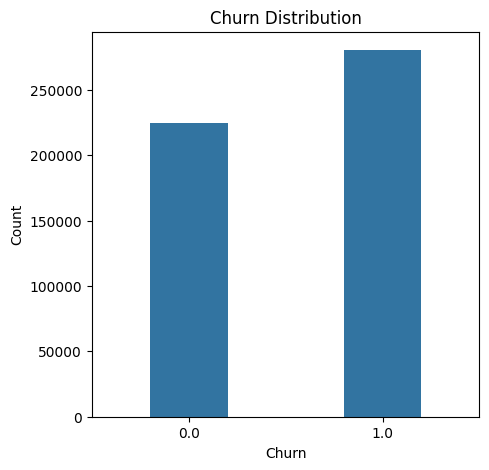

In [ ]:
plt.figure(figsize=(5, 5))

sns.countplot(
    data=df,
    x="Churn" ,width =.4
)

plt.title("Churn Distribution")
plt.xlabel("Churn")
plt.ylabel("Count")

plt.show()

/tmp/ipython-input-1847952540.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x=col, kde=True, bins=30 ,palette='Blues')
/tmp/ipython-input-1847952540.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x=col, kde=True, bins=30 ,palette='Blues')
/tmp/ipython-input-1847952540.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x=col, kde=True, bins=30 ,palette='Blues')
/tmp/ipython-input-1847952540.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x=col, kde=True, bins=30 ,palette='Blues')
/tmp/ipython-input-1847952540.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x=col, kde=True, bins=30 ,palette='Blues')
/tmp/ipython-input-1847952540.py:5: UserWarning: Ignoring `palette` because no `hue` variable has be

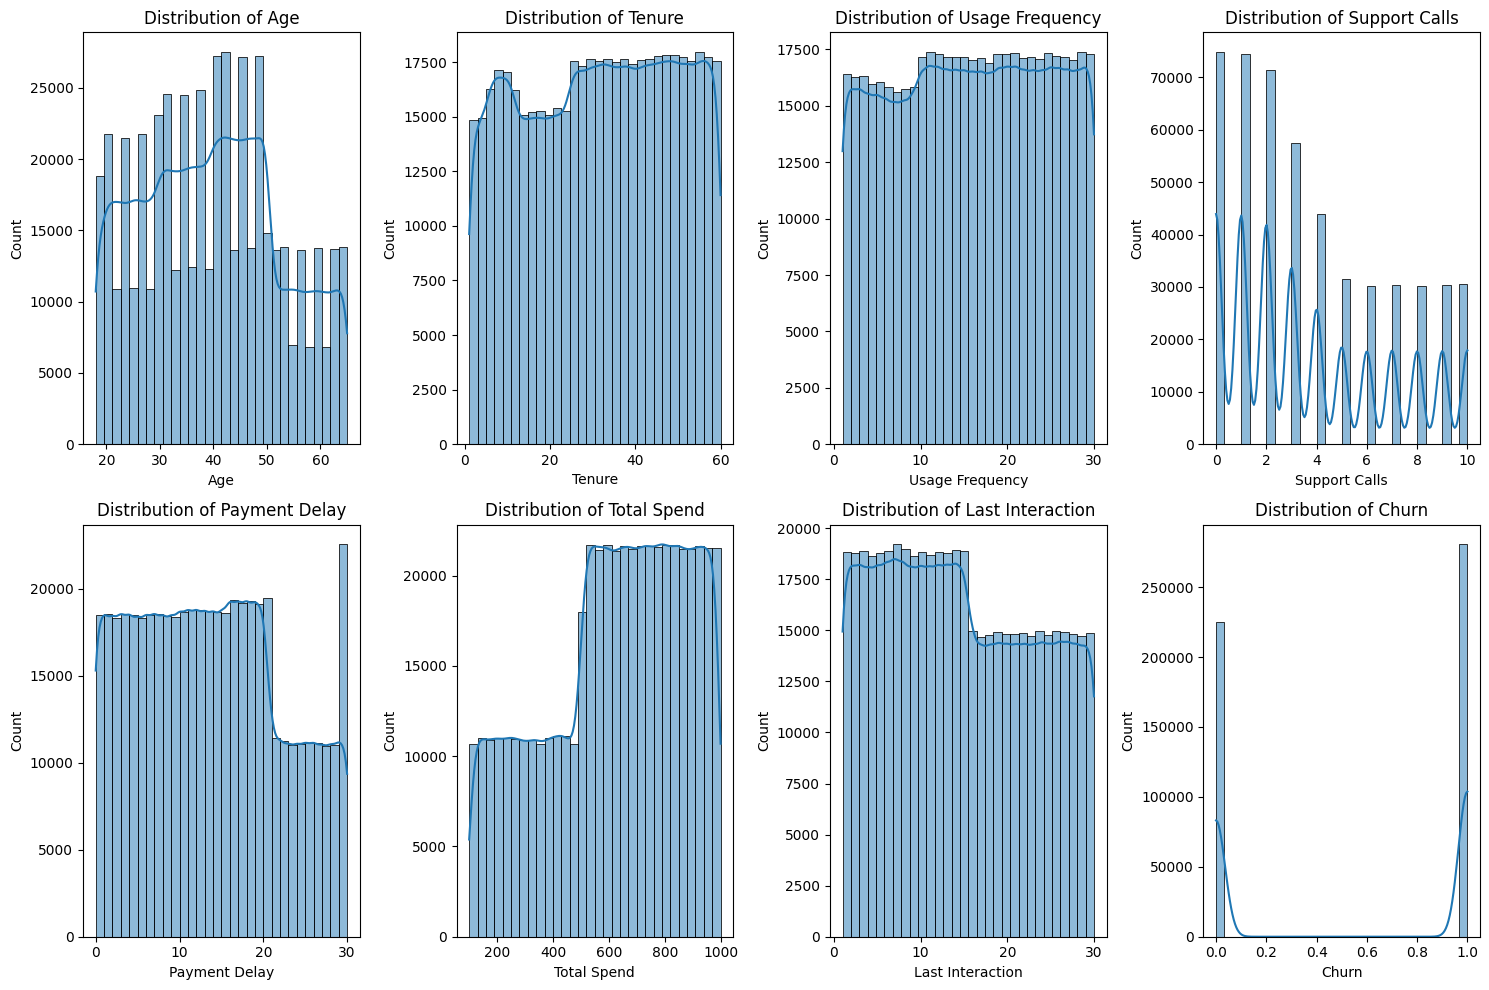

In [ ]:
plt.figure(figsize=(15, 10))

for i, col in enumerate(num_col, 1):
    plt.subplot(2 , 4, i)
    sns.histplot(data=df, x=col, kde=True, bins=30 ,palette='Blues')
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

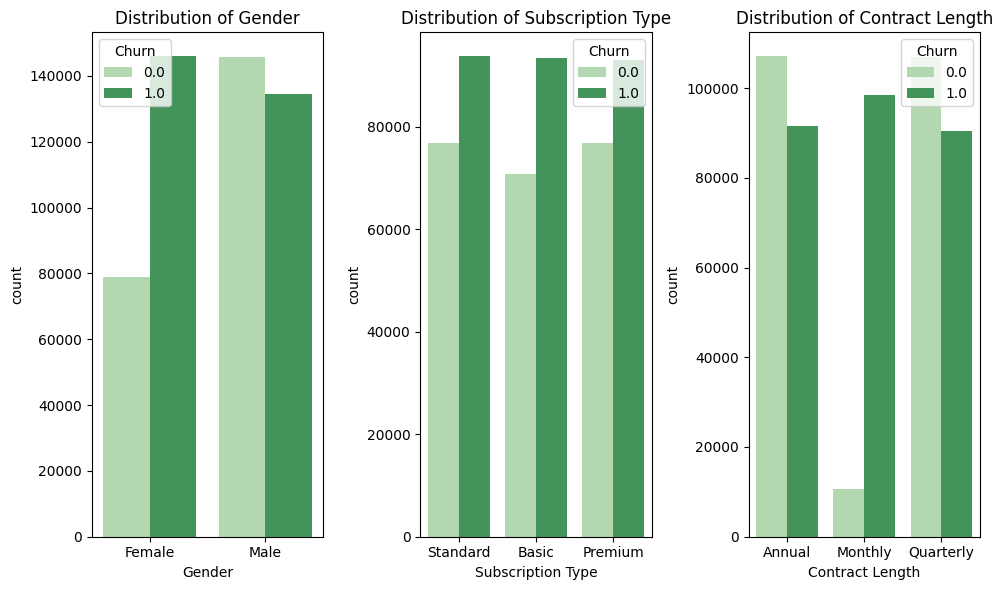

In [ ]:
plt.figure(figsize=(10, 6))

for i, col in enumerate(cat_col, 1):
    plt.subplot(1 , 3 , i)
    sns.countplot(data=df, x=col , hue = 'Churn' , palette="Greens")
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

/tmp/ipython-input-796182793.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Churn', y='Tenure', palette="Blues")


<Axes: xlabel='Churn', ylabel='Tenure'>

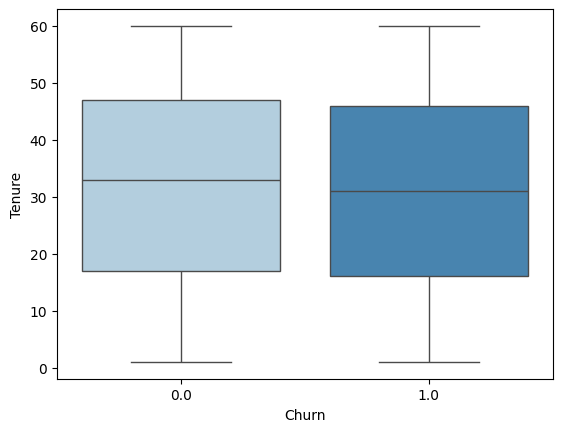

In [ ]:
sns.boxplot(data=df, x='Churn', y='Tenure', palette="Blues")

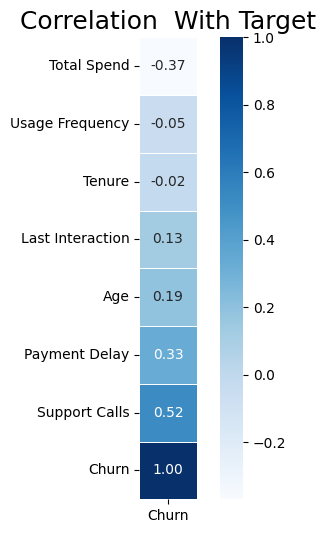

In [ ]:
plt.figure(figsize=(6, 6))

corr = df[num_col].corr()
corr_with_target = corr['Churn'].sort_values(ascending= True).to_frame()
sns.heatmap(
    data=corr_with_target,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    cbar=True,
    linewidths=0.5,
    linecolor='white',
    square=True
)

plt.title("Correlation  With Target", fontsize=18)
plt.show()

In [ ]:
print("\nStarting Modeling Phase...\n")

# 1. Define Feature Groups for the Pipeline
# (We define these explicitly to ensure the Pipeline maps them correctly)
numeric_features = ['Age', 'Tenure', 'Usage Frequency', 'Support Calls',
                    'Payment Delay', 'Total Spend', 'Last Interaction']
ordinal_features = ['Subscription Type', 'Contract Length']
nominal_features = ['Gender']


Starting Modeling Phase...



In [ ]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat_nom', OneHotEncoder(drop='first', sparse_output=False), nominal_features),
        ('cat_ord', OrdinalEncoder(categories=[
            ['Basic', 'Standard', 'Premium'],   # Subscription Order
            ['Monthly', 'Quarterly', 'Annual']  # Contract Order
        ]), ordinal_features)
    ],
    verbose_feature_names_out=False
)

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(solver='lbfgs', max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        device="cuda",          # This tells XGBoost to use the GPU
        tree_method="hist"      # This is the optimized algorithm for GPU
    )
}

param_grids = {
    "Logistic Regression": {
        "classifier__C": [0.01, 0.1, 1, 10]
    },
    "Decision Tree": {
        "classifier__max_depth": [3, 5, 10, None],
        "classifier__min_samples_split": [2, 5, 10]
    },
    "Random Forest": {
        "classifier__n_estimators": [50, 100, 150],
        "classifier__max_depth": [3, 5, 10, None]
    },
    "XGBoost": {
        "classifier__n_estimators": [50, 100, 150],
        "classifier__learning_rate": [0.01, 0.1, 0.2],
        "classifier__max_depth": [3, 5, 7]
    }
}

In [ ]:
results = []

for name, model in models.items():
    print(f"Training {name}...")

    # Pipeline: Preprocess -> Undersample -> Model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('sampler', RandomUnderSampler(random_state=42)),
        ('classifier', model)
    ])

    if name in param_grids:
        grid = GridSearchCV(
            pipeline,
            param_grid=param_grids[name],
            scoring='f1',
            cv=3,
            n_jobs=-1
        )
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        best_params = grid.best_params_
    else:
        best_model = pipeline.fit(X_train, y_train)
        best_params = "Default"

Training Logistic Regression...
Training Decision Tree...
Training Random Forest...
Training XGBoost...


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:01:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
y_pred = best_model.predict(X_test)

/usr/local/lib/python3.12/dist-packages/xgboost/core.py:774: UserWarning: [04:07:51] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


In [ ]:
# Convert the results list to a DataFrame
results_df = pd.DataFrame(results)

# Sort by F1-score (descending) so the best model is at the top
results_df = results_df.sort_values(by="F1-score", ascending=False).reset_index(drop=True)

# Display the table
print("Final Model Evaluation Summary:")
display(results_df)

Final Model Evaluation Summary:


,Model,Accuracy,Precision,Recall,F1-score,Best Params
0,XGBoost,0.94,0.9,1.0,0.94,"{'classifier__learning_rate': 0.2, 'classifier..."
1,XGBoost,0.94,0.9,1.0,0.94,"{'classifier__learning_rate': 0.2, 'classifier..."


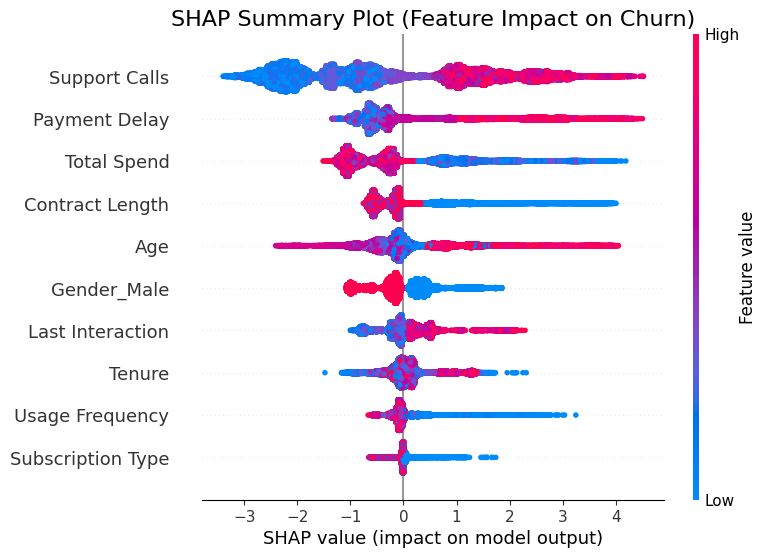

In [ ]:
import shap

preprocessor_step = best_model.named_steps['preprocessor']

xgboost_step = best_model.named_steps['classifier']

X_test_transformed = preprocessor_step.transform(X_test)

feature_names = (
    preprocessor_step.named_transformers_['num'].get_feature_names_out().tolist() +
    preprocessor_step.named_transformers_['cat_nom'].get_feature_names_out().tolist() +
    preprocessor_step.named_transformers_['cat_ord'].get_feature_names_out().tolist()
)

explainer = shap.TreeExplainer(xgboost_step)
shap_values = explainer.shap_values(X_test_transformed)

plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, show=False)
plt.title("SHAP Summary Plot (Feature Impact on Churn)", fontsize=16)
plt.show()

In [ ]:
#from google.colab import drive
import joblib
import os


#drive.mount('/content/drive')

folder_path = '/content/drive/MyDrive/Customer churn'
os.makedirs(folder_path, exist_ok=True)

file_path = os.path.join(folder_path, 'Best_Model.pkl')
joblib.dump(best_model, file_path)

['/content/drive/MyDrive/Customer churn/Best_Model.pkl']

In [ ]:
from huggingface_hub import login, HfApi

login(token="TOKEN")
api = HfApi()

model_repo = "Ravichandrachilde/Churn-with-SHAP"
api.upload_file(
    path_or_fileobj="/content/drive/MyDrive/Customer churn/Best_Model.pkl",
    path_in_repo="Best_Model.pkl",
    repo_id=model_repo,
    repo_type="model"
)

dataset_repo = "Ravichandrachilde/Churn"
api.upload_file(
    path_or_fileobj="/content/drive/MyDrive/Customer churn/Train.csv",
    path_in_repo="Train.csv",
    repo_id=dataset_repo,
    repo_type="dataset"
)
api.upload_file(
    path_or_fileobj="/content/drive/MyDrive/Customer churn/Test.csv",
    path_in_repo="Test.csv",
    repo_id=dataset_repo,
    repo_type="dataset"
)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...omer churn/Best_Model.pkl: 100%|##########| 3.28MB / 3.28MB            

No files have been modified since last commit. Skipping to prevent empty commit.


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  .../Customer churn/Train.csv: 100%|##########| 23.4MB / 23.4MB            

No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/datasets/Ravichandrachilde/Churn/commit/159f39a296f102410b0fc5089f6bf4a47a50452c', commit_message='Upload Test.csv with huggingface_hub', commit_description='', oid='159f39a296f102410b0fc5089f6bf4a47a50452c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Ravichandrachilde/Churn', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Ravichandrachilde/Churn'), pr_revision=None, pr_num=None)

/tmp/ipython-input-1313697694.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


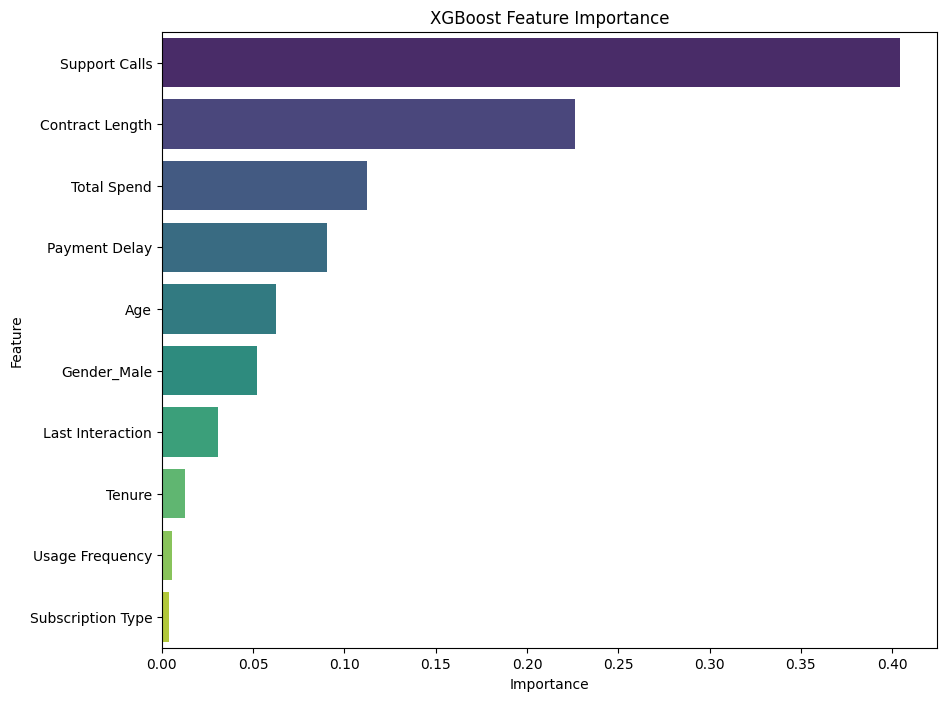

In [ ]:
# 1. Get the fitted preprocessor from inside the pipeline
# 'best_model' is the last model trained (XGBoost)
fitted_preprocessor = best_model.named_steps['preprocessor']

# 2. Extract feature names from that FITTED preprocessor
feature_names = (
    fitted_preprocessor.named_transformers_['num'].get_feature_names_out().tolist() +
    fitted_preprocessor.named_transformers_['cat_nom'].get_feature_names_out().tolist() +
    fitted_preprocessor.named_transformers_['cat_ord'].get_feature_names_out().tolist()
)

# 3. Extract importance from the classifier step
importances = best_model.named_steps['classifier'].feature_importances_

# 4. Create DataFrame and Plot
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('XGBoost Feature Importance')
plt.show()